# Networks: structure, evolution & processes
**Internet Analytics - Lab 2**

---

**Group:** *H*

**Names:**

* *BAFFOU Jérémy*
* *BASSETO Antoine*
* *PINTO Andrea*

---

#### Instructions

*This is a template for part 2 of the lab. Clearly write your answers, comments and interpretations in Markodown cells. Don't forget that you can add $\LaTeX$ equations in these cells. Feel free to add or remove any cell.*

*Please properly comment your code. Code readability will be considered for grading. To avoid long cells of codes in the notebook, you can also embed long python functions and classes in a separate module. Don’t forget to hand in your module if that is the case. In multiple exercises, you are required to come up with your own method to solve various problems. Be creative and clearly motivate and explain your methods. Creativity and clarity will be considered for grading.*

---

## 2.2 Network sampling

### Exercise 2.7: Random walk on the Facebook network

Crawl the Facebook graph to estimate the average age of users in the social network using the random walk approach of Algorithm 2.1, starting from node "a5771bce93e200c36f7cd9dfd0e5deaa". What is your estimation of the average age of a Facebook user? How many users did you visit to get this estimation? Hint: Refer to the helper notebook ix−lab2−helper.ipynb to get an example code illustrating how to query the API.

In [1]:
import random
import requests
import numpy as np
import matplotlib.pyplot as plt

### Facebook API setup and helper method

In [2]:
URL_TEMPLATE = 'http://iccluster041.iccluster.epfl.ch:5050/v1.0/facebook?user={user_id}'
start_uid = 'a5771bce93e200c36f7cd9dfd0e5deaa'

In [3]:
def request(id):
    url = URL_TEMPLATE.format(user_id=id)
    response = requests.get(url)
    return response.json()

### Exploring the first data sample

In [4]:
data = request(start_uid)

In [5]:
data['age']

13

In [6]:
data['friends'][0:5]

['0065470d21f5f095cc304a048984387a',
 '634f079997d1329f9504e68870b33a9f',
 '6005f35032ccbc32c007209c9547a709',
 '08f3a0aaa93613f038951a575d280c7f',
 'c55d0ff1eae9cddaf7210e9c71723525']

### Helpers methods
Note that the *get_next_uid* method was not implemented on our first trials. The latter allows us to select the next node to explore in an efficient way to avoid returning to a previously visited node. Indeed, with a completely random and unsupervised *RW* **we only had about 60% of unique visited nodes**. Meaning that we were looping a lot of times. Now with the *get_next_uid* method, if we choose a node whose friends have all been visited before, we will recursively find a new unvisited node from the list of friends of the previous node. This addition obviously brings us to **100% of unique visited nodes.**

In [44]:
def infos(users):
    print(f'Crawled {len(users)} nodes in the network')
    print(f'From which {len(set(users))} are unique users')

In [8]:
def get_next_uid(friends, users, i = 1):
    nf = [f for f in friends if f not in users]
    if len(nf) == 0:
        return get_next_uid(request(users[len(users) - i])['friends'], users, i+1)
    else:
        return random.choice(nf)

In [23]:
def random_walk(sid, iters, pt = True):
    data = request(sid)
    
    users = []
    ages = []
    degrees = []
    prevs = []
    
    users.append(sid)
    ages.append(data['age'])
    degrees.append(len(data['friends']))
    
    epoch = 1
    uid = random.choice(data['friends'])
    
    while epoch < iters:
        data = request(uid)
        
        users.append(uid)
        ages.append(data['age'])
        degrees.append(len(data['friends']))
        
        uid = get_next_uid(data['friends'], users)
        epoch += 1
        if pt:
            print(epoch, end='\r')
    
    return users, ages, degrees

### Compute statistics

We can compute the average age statistics in two different ways.

- A **naive** one that will be biased on caracteristics of sample nodes we explore in the graph. Indeed high-degree nodes are sampled more frequently !
- A **smart** one that will compute an unbiased statistic by weighting by node degrees. Correctness holds with Markov chain theory. 

The idead to get the unbiased estimator from our *RW* is to compensate the degree bias. To get rid of it we compute the following :

$$ \hat{F} = \frac{2m}{nT} * \sum_{i} \frac{f(x_i)}{deg(x_i)} $$

Where 

- $ \hat{F} $ is our global unbiased statistic.
- $ f(x_i) $ is a node statistic (here it's age).
- $ deg(x_i) $ is the degree of the considered node.
- $ T $ the number of iterations of our *RW*. 
- $ m $ is the number of *edges* in our graph.
- $ n $ is the number of *vertex* in our graph.

However **we do not have the knowledge of $m$ and $n$ !** <br>
We elimate those constants by esimating a normalization constant from sample path. <br>
$ \hat{F} $ becomes :  

$$ \hat{F} = \frac{1}{\sum_{i} deg(x_i)^{-1}} * \sum_{i} \frac{f(x_i)}{deg(x_i)} $$

**NB** **:** We used to filter to get only unique values. But this is deprecated because the *RW* already provides us with a list of unique nodes.

In [45]:
def average_age_naive(users, ages):
    uniques, indices = np.unique(users, return_index=True)
    filtered_ages = np.array(ages)[indices]
    return np.sum(filtered_ages) / len(uniques)

In [11]:
def average_age_smart(users, ages, degrees):
    uniques, indices = np.unique(users, return_index=True)
    filtered_ages = np.array(ages)[indices]
    filtered_degrees = np.array(degrees)[indices]
    return np.sum(filtered_ages / filtered_degrees) / np.sum(1/filtered_degrees)

### First results

In [12]:
users, ages, degrees = random_walk(start_uid, 10000)

In [13]:
infos(users)

Crawled 10000 nodes in the network
From which 10000 are unique users


In [14]:
average_age_naive(users, ages)

23.9878

In [15]:
average_age_smart(users, ages, degrees)

45.60043095533572

### Plot evolution

In [16]:
def evolution(users, ages, degrees):
    avgs = []
    for i in range(1, len(users)):
        avgs.append(average_age_smart(users[0:i], ages[0:i], degrees[0:i]))
    return avgs

In [17]:
avgs = evolution(users, ages, degrees)

Text(0, 0.5, 'Age statistic')

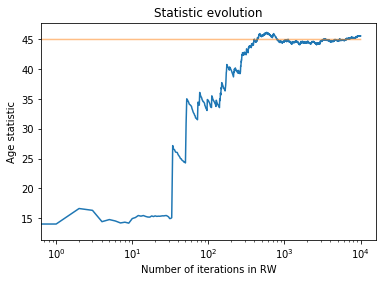

In [36]:
plt.plot(avgs)
plt.plot([45]*len(avgs), alpha=0.5)
plt.xscale('log')
plt.title('Statistic evolution')
plt.xlabel('Number of iterations in RW')
plt.ylabel('Age statistic')

#### Comment on the plot and the result
We can see that on this *RW* instance we clearly stabilize around the correct *average age* after the first **1000** iterations. Note that this is not really exhaustive as it could change depending on the path we take during our *RW*. Let's try below a few different runs with less iterations (to compute faster and be more eco-friendly). We'll see if we still reach our threshold after a thousand iterations and how the *age statistics* evolves during time according to the different *RW* paths.

### More RW trials

In [40]:
def runs(x, iters):
    for i in range(x):
        print(i + 1, end='\r')
        users, ages, degrees = random_walk(start_uid, iters, pt=False)
        avgs = evolution(users, ages, degrees)
        plt.figure()
        plt.plot(avgs)
        plt.plot([45]*len(avgs), alpha=0.5)
        plt.xscale('log')
        plt.title('Statistic evolution for try : ' + str(i + 1))
        plt.xlabel('Number of iterations in RW')
        plt.xlabel('Age statistic')
        plt.show

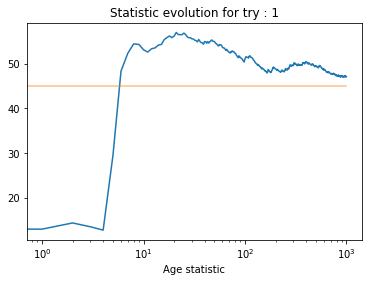

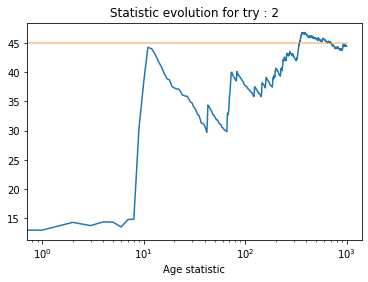

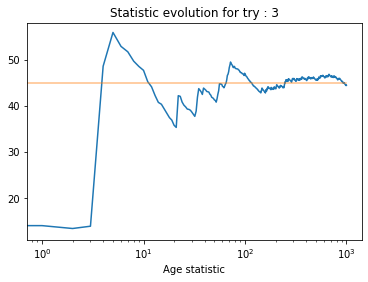

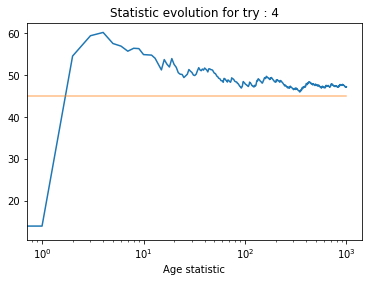

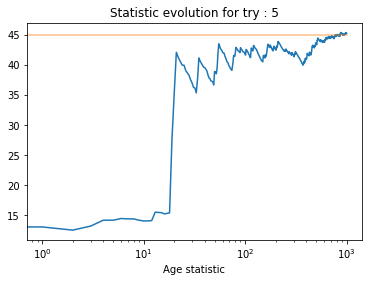

In [43]:
runs(5, 1000)

#### Comment on the plots and the results
As expected, we have quite different behaviors depending on the path explored by our random walk. In general (to be taken with care) the threshold is largely reached in the first 1000 iterations. This is especially the case if we quickly reach a cluster of older people, which quickly increases the average age.